In [3]:
import json
import requests
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from datetime import datetime

In [4]:
train_bit = pd.read_csv('C:\\Users\\sidda\\Documents\\Siddartha\\Columbia\\EECS 6893\\Project\\data\\train_bitcoin.csv')
del train_bit['Unnamed: 0']

In [5]:
bit = train_bit.set_index('timestamp')
bit = bit.reindex(range(bit.index[0],bit.index[-1]+60,60),method='pad')
(bit.index[1:]-bit.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [6]:
import time

totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# Lets try predciting price after 15mins

X_btc = pd.concat([bit.Open,bit.Count,bit.High,bit.Low,bit.Close], axis=1)
y_btc = bit.Close
train_window = [totimestamp("01/05/2021"), totimestamp("06/05/2021")]
test_window = [totimestamp("07/05/2021"), totimestamp("08/05/2021")]
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

In [7]:
y_btc_train = y_btc_train.reshape(-1,1)
y_btc_test = y_btc_test.reshape(-1,1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.fit_transform(X_btc_test)
y_btc_train_scaled = scaler.fit_transform(y_btc_train)
y_btc_test_scaled = scaler.fit_transform(y_btc_test)

In [21]:
from itertools import chain
X_train = []
y_train = []
X_test = []
y_test = []
length = 60
duration = 90 #Add 15min gap between features and target
for i in range(len(X_btc_train_scaled)-length-duration):
    temp = []
    for j in range(length):
        temp = list(chain(temp,X_btc_train_scaled[i+j]))
    X_train.append(temp)
    y_train.append(y_btc_train_scaled[i+length+duration])
    
for i in range(len(X_btc_test_scaled)-length-duration):
    temp = []
    for j in range(length):
        temp = list(chain(temp,X_btc_test_scaled[i+j]))
    X_test.append(temp)
    y_test.append(y_btc_test_scaled[i+length+duration])

In [22]:
X_btc_train_scaled = np.array(X_train)
y_btc_train_scaled = np.array(y_train)
X_btc_test_scaled = np.array(X_test)
y_btc_test_scaled = np.array(y_test)
print(X_btc_train_scaled.shape,y_btc_train_scaled.shape,X_btc_test_scaled.shape,y_btc_test_scaled.shape)

(7051, 300) (7051, 1) (1291, 300) (1291, 1)


In [43]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()
sgd.fit(X_btc_train_scaled,np.ravel(y_btc_train_scaled))
y_pred_lr_btc = sgd.predict(X_btc_test_scaled)

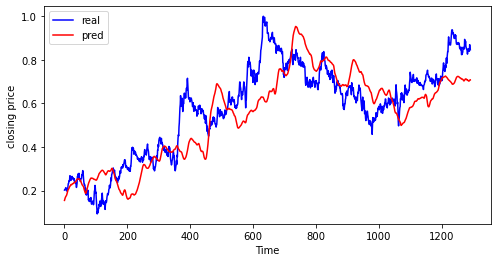

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(y_btc_test_scaled,color='blue',label = 'real');
plt.plot(y_pred_lr_btc,color='red', label = 'pred');
plt.legend()
plt.xlabel('Time')
plt.ylabel('closing price')
plt.show()

In [45]:
import tensorflow as tf

y_btc_test_scaled_temp = np.ravel(y_btc_test_scaled.T)

accuracy = (100-np.average(tf.keras.metrics.mean_absolute_percentage_error(y_btc_test_scaled_temp[np.nonzero(y_btc_test_scaled_temp)]
                                                                           ,y_pred_lr_btc[np.nonzero(y_btc_test_scaled_temp)]).numpy()))
print(accuracy)

79.74447343936698


In [6]:
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low
X_btc = pd.concat([log_return(bit.VWAP,periods=5), log_return(bit.VWAP,periods=1).abs(), 
               upper_shadow(bit), lower_shadow(bit)], axis=1)
y_btc = bit.Target

In [7]:
import time

totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

train_window = [totimestamp("01/05/2021"), totimestamp("06/05/2021")]
test_window = [totimestamp("07/05/2021"), totimestamp("08/05/2021")]
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

In [8]:
y_btc_train = y_btc_train.reshape(-1,1)
y_btc_test = y_btc_test.reshape(-1,1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.fit_transform(X_btc_test)
y_btc_train_scaled = scaler.fit_transform(y_btc_train)
y_btc_test_scaled = scaler.fit_transform(y_btc_test)

In [9]:
print(X_btc_train_scaled.shape,y_btc_train_scaled.shape,X_btc_test_scaled.shape,y_btc_test_scaled.shape)

(7201, 4) (7201, 1) (1441, 4) (1441, 1)


In [10]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()
sgd.fit(X_btc_train_scaled,np.ravel(y_btc_train_scaled))
y_pred_lr_btc = sgd.predict(X_btc_test_scaled)

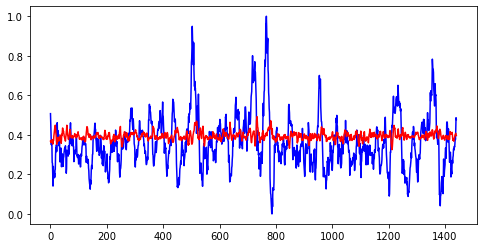

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(y_btc_test_scaled,color='blue',label = 'real');
plt.plot(y_pred_lr_btc,color='red', label = 'pred');
plt.show()

In [12]:
import tensorflow as tf

y_btc_test_scaled_temp = np.ravel(y_btc_test_scaled.T)

accuracy = (100-np.average(tf.keras.metrics.mean_absolute_percentage_error(y_btc_test_scaled_temp[np.nonzero(y_btc_test_scaled_temp)]
                                                                           ,y_pred_lr_btc[np.nonzero(y_btc_test_scaled_temp)]).numpy()))
print(accuracy)

53.36129815605361


In [13]:
train_eth = pd.read_csv('C:\\Users\\sidda\\Documents\\Siddartha\\Columbia\\EECS 6893\\Project\\data\\train_ethereum.csv')
del train_eth['Unnamed: 0']

In [14]:
eth = train_eth.set_index('timestamp')
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')
(eth.index[1:]-eth.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [15]:
import time

totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# Lets try predciting price after 15mins

X_eth = pd.concat([eth.Open,eth.Count,eth.High,eth.Low,eth.Close], axis=1)
y_eth = eth.Close
train_window = [totimestamp("01/05/2021"), totimestamp("06/05/2021")]
test_window = [totimestamp("07/05/2021"), totimestamp("08/05/2021")]
X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

In [16]:
y_eth_train = y_eth_train.reshape(-1,1)
y_eth_test = y_eth_test.reshape(-1,1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.fit_transform(X_eth_test)
y_eth_train_scaled = scaler.fit_transform(y_eth_train)
y_eth_test_scaled = scaler.fit_transform(y_eth_test)

In [23]:
from itertools import chain
X_train = []
y_train = []
X_test = []
y_test = []
length = 60
duration = 90 #Add 15min gap between features and target
for i in range(len(X_eth_train_scaled)-length-duration):
    temp = []
    for j in range(length):
        temp = list(chain(temp,X_eth_train_scaled[i+j]))
    X_train.append(temp)
    y_train.append(y_eth_train_scaled[i+length+duration])
    
for i in range(len(X_eth_test_scaled)-length-duration):
    temp = []
    for j in range(length):
        temp = list(chain(temp,X_eth_test_scaled[i+j]))
    X_test.append(temp)
    y_test.append(y_eth_test_scaled[i+length+duration])

In [24]:
X_eth_train_scaled = np.array(X_train)
y_eth_train_scaled = np.array(y_train)
X_eth_test_scaled = np.array(X_test)
y_eth_test_scaled = np.array(y_test)
print(X_eth_train_scaled.shape,y_eth_train_scaled.shape,X_eth_test_scaled.shape,y_eth_test_scaled.shape)

(7051, 300) (7051, 1) (1291, 300) (1291, 1)


In [37]:
X_train_scaled = np.concatenate([X_btc_train_scaled,X_eth_train_scaled],axis=1)
y_train_scaled = y_btc_train_scaled
X_test_scaled = np.concatenate([X_btc_test_scaled,X_eth_test_scaled],axis=1)
y_test_scaled = y_btc_test_scaled
print(X_train_scaled.shape,y_train_scaled.shape,X_test_scaled.shape,y_test_scaled.shape)

(7051, 600) (7051, 1) (1291, 600) (1291, 1)


In [40]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()
sgd.fit(X_train_scaled,np.ravel(y_train_scaled))
y_pred_lr = sgd.predict(X_test_scaled)

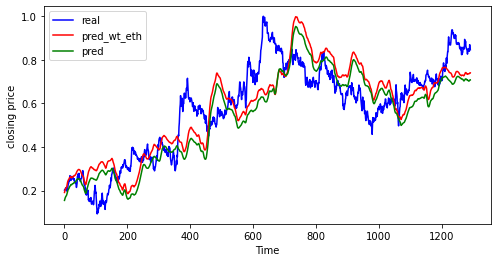

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(y_test_scaled,color='blue',label = 'real');
plt.plot(y_pred_lr,color='red', label = 'pred_wt_eth');
plt.plot(y_pred_lr_btc,color='green', label = 'pred');
plt.legend()
plt.xlabel('Time')
plt.ylabel('closing price')
plt.show()

In [42]:
import tensorflow as tf

y_btc_test_scaled_temp = np.ravel(y_btc_test_scaled.T)

accuracy = (100-np.average(tf.keras.metrics.mean_absolute_percentage_error(y_btc_test_scaled_temp[np.nonzero(y_btc_test_scaled_temp)]
                                                                           ,y_pred_lr_btc[np.nonzero(y_btc_test_scaled_temp)]).numpy()))
print(accuracy)

79.69544227891902
